## Part 1

EDA

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_json("logins.json")

In [3]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
df.sample(10)

,login_time
36126,1970-02-19 13:47:29
87184,1970-04-07 13:41:31
15952,1970-01-24 04:37:49
4188,1970-01-08 05:55:04
3562,1970-01-07 10:40:55
77695,1970-03-29 14:31:42
42524,1970-02-25 22:13:22
84513,1970-04-04 12:28:33
84382,1970-04-04 06:54:13
24277,1970-02-05 23:09:55


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [6]:
# Settings the count of each entry to 1
df['count'] = 1

# setting the login time to index of the data frame
df.index = df['login_time']

# Dropping original login_time column

df.drop(['login_time'], inplace = True, axis = 1)

df.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [8]:
# creating a new dataframe with 15 minute resample values

df_15m = df['count'].resample('15Min').sum()

df_15m.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, Name: count, dtype: int64

In [9]:
df_15m = pd.DataFrame(df_15m)
df_15m.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [14]:
df_15m[df_15m['count'].isna()]

,count
login_time,


No missing values. Indicating there is atleast one login every 15 minutes.

<AxesSubplot:xlabel='login_time'>

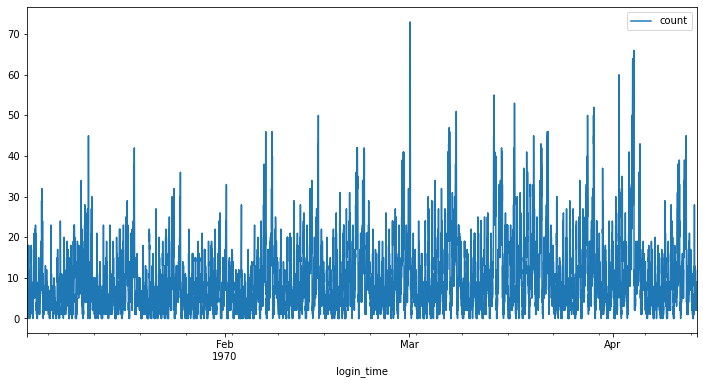

In [15]:
df_15m.plot(kind = 'line', figsize = (12,6))

The plot above shows a pattern in the values. Lets take a deeper look by decomposing the model

In [16]:
from statsmodels.tsa import seasonal

<ipython-input-22-f6eaa2398a20>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decompose = seasonal.seasonal_decompose(df_15m['count'], model = 'additive', freq = 96)


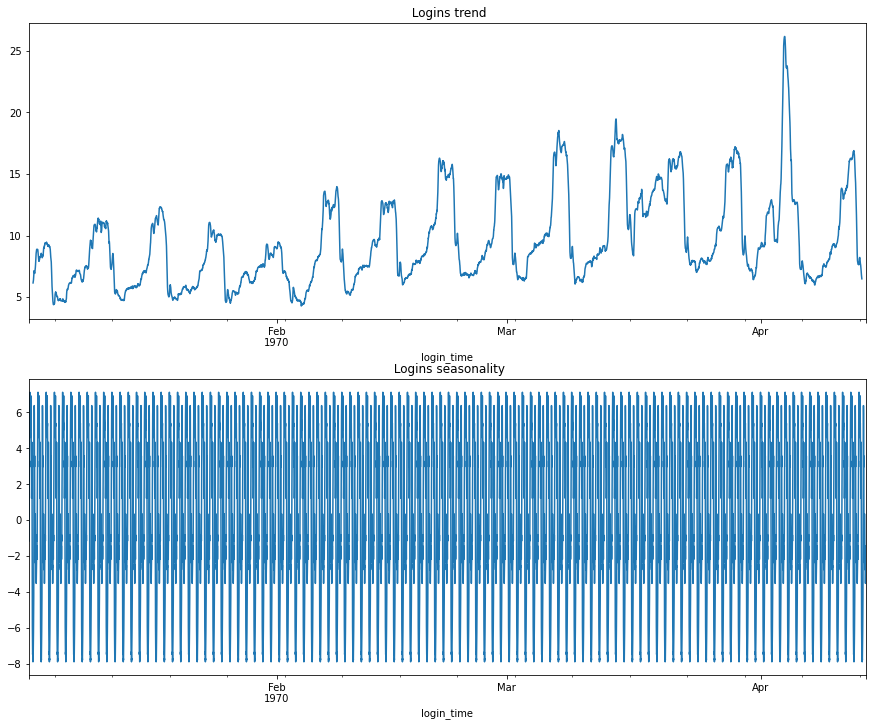

In [22]:
plt.figure(figsize = (15,12))

decompose = seasonal.seasonal_decompose(df_15m['count'], model = 'additive', freq = 96)

plt.subplot(2, 1, 1)
decompose.trend.plot()
plt.title(' Logins trend')

plt.subplot(2, 1, 2)
decompose.seasonal.plot()
plt.title(' Logins seasonality')

plt.show()

Notice an apparent trend in the data on a monthly basis. This motivates us to look into the data on a weekly and daily basis

Text(0.5, 0, ' Login hour of the day')

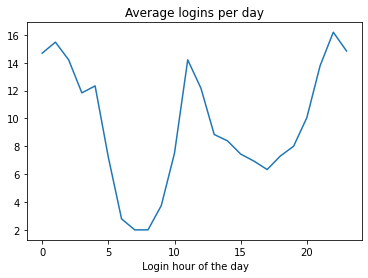

In [23]:
daily = df_15m.groupby(df_15m.index.hour).mean()
plt.plot(daily)
plt.title('Average logins per day')
plt.xlabel(' Login hour of the day')

([<matplotlib.axis.XTick at 0x7fde1e16b190>,
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

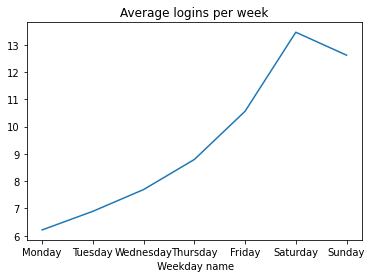

In [31]:
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly = df_15m.groupby(df_15m.index.weekday).mean()


plt.plot(weekly)
plt.title('Average logins per week')
plt.xlabel(' Weekday name')
plt.xticks(range(len(day_of_week)), day_of_week)

we clearly see a significant increase in login over the weekend especially Saturdays. Additionally, we see a pattern every 10 hours or so within the same day with an increaseing trend.

## Part 2

Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
 - A key metric in this experiment would be to observe the number of trips made by a pool of drivers between the two cities under different time frames. One during the day- for drivers from Gotham entering into Metropolis, and one during the night - for drivers entering Gotham from Metropolis. This metric directly shows driver patterns within the cities and between them. 
 
  These observations would have to be measured in two parts. 
   1) Making observations for a certain time period - 2 weeks or even a month- before implementing the toll reimbursement plan.

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a) how you will implement the experiment

b) what statistical test(s) you will conduct to verify the significance of the observation

c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

One way to approach this problem would be : 

 - We take a sample of drivers - 200 in each city and focus on specific time frames based on the circadian patterns of the two cities. So for Gotham we observe the driver patterns during the night and for Metropolis we observe the driver patterns during the day.  
 
 - For each of the drivers in the sample, we can calculate the metric described above as a ratio of the number of trips made between Gotham and Metropolis to the total number of trips made by the driver ( this includes trips made with the same city).
 
 - We make these observations in two phases : 
   - Phase 1 - For a time period of two weeks before the implementation of the reimbursement program, we calculate the metric.
   
   - Phase 2 - For a time period of two weeks after the implementation of the reimbursement program, we calculate the metric. 
   
 - Once we make these observations we run a hypothesis test: 
   - H0 : The reimbursement program has no effect on the mean number of trips made between the two cities in their respective time windows. That is the average numebr of trips made before and after the implementation of the reimbursement are the same.
   
   - H1 : The reimbursement program has impacted the number of trips made between the two cities in their respective time woindows. That is the average number of trips made before and after the implementation are different. 
   
   Note: In both of the above cases, the average number of trips is calculated as a ratio described in the approach above. 
   
 - We use a one tailed t-test as the test statistic to check if the results are statistically significant or not with a 5% confidence interval.
 
 If the p value is less than 0.05 we can reject the null hypothesis and recommend to continue with the reimbursement program and test with a larger pool of drivers in a few months again.
 
 If the p value is greater than 0.05, we can say no conclusive results were obtained.

## Part 3

Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

In [34]:
df1 = pd.read_json("ultimate_data_challenge.json")

In [35]:
df1.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [37]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### Data Cleaning

We start by looking at the phone column. Since that is an independent column and there is no way to predict that based on the information in this column, we can drop the rows that do not have any phone information. 

In [41]:
df1 = df1.drop(df1[df1['phone'].isna() == True].index,axis = 0)

In [42]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    41578 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [46]:
# Replacing the na values of the average ratings using the median values

avg_of_driver = df1['avg_rating_of_driver'].median()

In [49]:
avg_by_driver = df1['avg_rating_by_driver'].median()

In [50]:
df1['avg_rating_of_driver'] = df1['avg_rating_of_driver'].fillna(value = avg_of_driver)
df1['avg_rating_by_driver'] = df1['avg_rating_by_driver'].fillna(value = avg_by_driver)

In [51]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


We have cleaned all the missing values in the dataset.

In [52]:
# Converting the date column to datetime data type

df1['last_trip_date'] = pd.to_datetime(df1['last_trip_date'])

In [53]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  object        
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(6), int

In [56]:
# creating the active column based on the last trip date
# if difference between last trip date and current date is <30 the user is active( 1) else inactive (0)

# current date - the last of the current trips in the data set and the day the data information was pulled

recent_date = df1['last_trip_date'].max()



In [65]:
df1['active'] = df1['last_trip_date'].apply(lambda trip_date: 1 if (recent_date - trip_date).days <= 30 else 0)

In [66]:
df1.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [68]:
df1.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active
count,49604.000000,49604.00000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000
mean,2.277256,4.64977,1.074991,8.875314,60.883832,5.785418,4.778748,0.376401
std,3.793300,0.57582,0.222666,19.989018,37.086239,5.669709,0.446440,0.484487
min,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.50000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.90000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.00000,1.050000,8.700000,100.000000,6.930000,5.000000,1.000000
max,125.000000,5.00000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000


In [69]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  object        
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
 12  active                  49604 non-null  int64 

Looking at the describe method above we see that of the users who signed up, only 37.6% of them are curently active and have taken a trip in the last month.

### EDA and Feature engineering

We start by creating dymmy variables for the categorical variables. Of the given features - 'city', 'phone', 'ultimate_black_user' are the categorical variables. 

We convert the signup_date to a date time variable


In [70]:
df1['signup_date'] = pd.to_datetime(df1['signup_date'])

In [71]:
df2 = pd.get_dummies(df1, columns = ['city', 'phone', 'ultimate_black_user' ])
df2.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,1,0,1,0


In [72]:
# creating the target variable

y = df2['active']

# creating features data set
X = df2.drop(['signup_date', 'last_trip_date', 'active'], axis = 1)


In [73]:
len(df2)

49604

<AxesSubplot:xlabel='active', ylabel='avg_dist'>

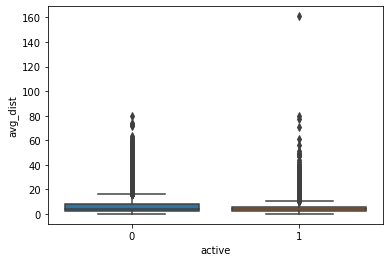

In [75]:
# Using a box plot to explore active users based on avg distance traveled by that user
sns.boxplot(data = df2, x = 'active', y = 'avg_dist')

We note that while the distributio of average distance seems to be fairly same, one active user has traveled longer distances. 

<AxesSubplot:xlabel='active', ylabel='weekday_pct'>

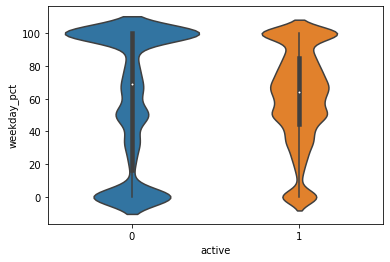

In [77]:
# Avg rating of driver vs active user

sns.violinplot(data = df2, x = 'active', y = 'weekday_pct')

We see that while inactive users mainly focused on the extreme - either they dont use the app at all or they use it very frequently, active users on the other hand have a more uniformly distributed usage. 

### Predictive modeling

In order to determine features that are the best predictors, we use a Random Forest Classifier as that also helps us visualize the feature importance of each feature


In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [79]:
# Random Forest Classifier
rf_scaler = StandardScaler()
df_rf = rf_scaler.fit_transform(X)


In [80]:
# creating train test split and model
X_tr, X_te, y_tr, y_te = train_test_split(df_rf, y, test_size = 0.25, random_state = 123)

rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X_tr, y_tr)
y_predict = rf.predict(X_te)


In [81]:
rf.score(X_te, y_te)

0.7610676558342069

In [82]:
cross_val_rf = cross_val_score(rf, X_te, y_te, cv = 5)

In [83]:
cross_val_rf

array([0.76259573, 0.75685484, 0.74354839, 0.75      , 0.75201613])

In [85]:
print('Mean cross val score: ', np.mean(cross_val_rf))

Mean cross val score:  0.7530030164735864


In [90]:
# Displaying important features

feature_dict = {'Feature Name' : list(X), 'Importances' : list(rf.feature_importances_)}
feature_importance = pd.DataFrame(feature_dict)

In [91]:
feature_importance

,Feature Name,Importances
0,trips_in_first_30_days,0.081229
1,avg_rating_of_driver,0.080766
2,avg_surge,0.069673
3,surge_pct,0.076213
4,weekday_pct,0.133269
5,avg_dist,0.299444
6,avg_rating_by_driver,0.116148
7,city_Astapor,0.016694
8,city_King's Landing,0.045959
9,city_Winterfell,0.011243


In [93]:
feature_importance.sort_values(by = 'Importances', ascending = False)

,Feature Name,Importances
5,avg_dist,0.299444
4,weekday_pct,0.133269
6,avg_rating_by_driver,0.116148
0,trips_in_first_30_days,0.081229
1,avg_rating_of_driver,0.080766
3,surge_pct,0.076213
2,avg_surge,0.069673
8,city_King's Landing,0.045959
10,phone_Android,0.019924
11,phone_iPhone,0.018595


We see that average distance and percentage of trips made on weekdays are the two most importance features with city location and being an Ultimate Black user being relatively unimportant.

The accuracy of our model is on an average aout 75%. 

We try and fit our data to another model to see how it performs.

### K Nearest Neighbors

In [95]:
from sklearn.neighbors import KNeighborsClassifier

In [96]:
knn_model = KNeighborsClassifier()

param_grid = {'n_neighbors' : np.arange(1, 20,5)}


knn_cv = GridSearchCV(knn_model, param_grid, cv = 5)
knn_cv.fit(X_tr, y_tr)



GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  6, 11, 16])})

In [97]:
knn_cv.best_params_

{'n_neighbors': 16}

In [98]:
knn_cv.score(X_tr, y_tr)

0.7832432868317071

In [99]:
knn_cv.score(X_te, y_te)

0.7610676558342069

In [102]:
knn_best = KNeighborsClassifier(n_neighbors = 16)
knn_best.fit(X_tr, y_tr)


KNeighborsClassifier(n_neighbors=16)

We get the best value as 16 that is nearest neighbors value of 16 and a accuracy of 76% on our test data set. This is not very different from our Random Forest Model.

In [100]:
from sklearn import metrics

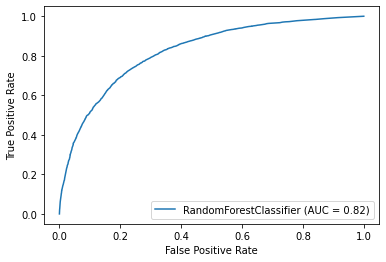

In [101]:
metrics.plot_roc_curve(rf, X_te, y_te)
plt.show()

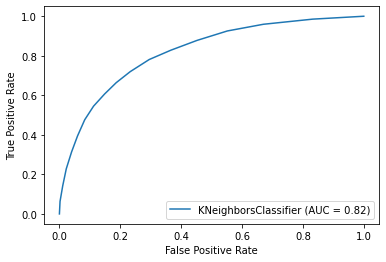

In [103]:
metrics.plot_roc_curve(knn_best, X_te, y_te)

In [104]:
y_rf_pred = rf.predict(X_te)
y_knn_pred = knn_best.predict(X_te)


In [106]:
from sklearn.metrics import confusion_matrix, classification_report

In [108]:
print(classification_report(y_te, y_rf_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      7820
           1       0.68      0.67      0.67      4581

    accuracy                           0.76     12401
   macro avg       0.74      0.74      0.74     12401
weighted avg       0.76      0.76      0.76     12401



In [109]:
print(classification_report(y_te, y_knn_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      7820
           1       0.71      0.61      0.65      4581

    accuracy                           0.76     12401
   macro avg       0.75      0.73      0.74     12401
weighted avg       0.76      0.76      0.76     12401



As we can see that both models have similar accuracies and hence similar ROC curves. The average distance for each trip and percentage of trips made on weekdays appear to be the most prominent features in these cases. 

What we need to keep in mind is that the metric of importance in this case will depend on the problem we are trying to solve. If we are more concerned with the number of users who accurately leave vs number of users who falsely stay active. So if the recall is more important, we can lower the threshold of the probability at which we calculate whether a user will stay active or not. This will tilt the classification in teh favor of the recall score at the cost of affecting the precision. 